## Table of Contents
0. Initial Setup
1. Utility Functions
2. Network Loading and Preprocessing
   - 2.1 Load Networks
3. Community Detection Analysis
   - 3.1 Apply Infomap, Louvain and Greedy Algorithms
4. Comparison with Ground Truth
   - 4.1 Compute Jaccard Index, NMI, and NVI
   - 4.2 Plots
     - 4.2.1 Number of Detected Communities
     - 4.2.2 Modularity vs prr
     - 4.2.3 Jaccard Index vs prr
     - 4.2.4 Normalized Mutual Information (NMI) vs prr
     - 4.2.5 Variation of Information (NVI) vs prr
5. Network Visualization
   - 5.1 Color-coded Community Visualization for prr = 0.02, 0.16, 1.00
6. Discussion
   - 6.1 Limitations of Modularity
     - Q1: What are the limitations of modularity as a metric for evaluating community detection results?
     - Q2: Can we state that a network with Q = 0.4 has community structure?
   - 6.2 Observations on Differences between Algorithms
     - Q1: What is the difference between Louvain, Greedy and Infomap Algorithms?
     - Q2: Are the modularity values obtained equal? Why?



In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from collections import Counter
from cdlib import evaluation
from cdlib.evaluation import normalized_mutual_information, variation_of_information, jaccard_index
import community as community_louvain
from tqdm import tqdm
from itertools import combinations
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

try:
    import infomap
except:
    !pip install infomap
    import infomap

try:
    import clusim
except:
    !pip install clusim

plt.style.use('ggplot')
%matplotlib inline

REPORT_FOLDER = "report"
PLOTS_FOLDER = "plots"

CLUSTERS_FOLDER = "partitions_clu"

for folder in [REPORT_FOLDER, PLOTS_FOLDER, CLUSTERS_FOLDER]:
    if not os.path.exists(folder):
        os.makedirs(folder)

for folder in [REPORT_FOLDER, PLOTS_FOLDER]:
    if not os.path.exists(folder):
        os.makedirs(folder)


## 1. Utility Functions
Here we define helper functions used throughout the notebook.

In [15]:
def load_network(path):
    """
    Load a Pajek-format network and convert to simple undirected NetworkX graph.

    Parameters:
        path (str): Path to .net file.

    Returns:
        G (networkx.Graph): Cleaned graph with integer-labeled nodes.
    """
    G = nx.read_pajek(path)
    G = nx.Graph(G)
    G = nx.convert_node_labels_to_integers(G)
    return G

def detect_communities_infomap(G):
    """
    Apply Infomap algorithm to detect communities in G.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    im = infomap.Infomap()
    mapping = im.add_networkx_graph(G)
    im.run()
    modules = im.get_modules()
    community_dict = defaultdict(set)
    for node, com in modules.items():
        community_dict[com].add(mapping[node])
    return list(community_dict.values())


def detect_communities_louvain(G):
    """
    Apply Louvain algorithm to detect communities in G using NetworkX interface.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    return list(nx.community.louvain_communities(G))


def detect_communities_greedy(G):
    """
    Apply Greedy modularity algorithm to detect communities in G.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    return list(greedy_modularity_communities(G))

def ground_truth_partition(N=300, block_size=60):
    """
    Generate the ground-truth partition from known SBM structure.

    Parameters:
        N (int): Total number of nodes.
        block_size (int): Size of each block.

    Returns:
        list[set]: Ground truth communities.
    """
    return [set(range(i * block_size, (i + 1) * block_size)) for i in range(N // block_size)]

def save_partition_to_clu(partition, path, N=300):
    """
    Save a partition (list of sets) to a Pajek .clu file.

    Parameters:
        partition (list of sets): Detected communities.
        path (str): Output path to save the .clu file.
        N (int): Total number of nodes in the graph.
    """
    node_labels = [0] * N
    for i, community in enumerate(partition):
        for node in community:
            node_labels[node] = i + 1  # Pajek indexing starts from 1

    with open(path, 'w') as f:
        f.write(f"*Vertices {N}\n")
        for label in node_labels:
            f.write(f"{label}\n")


## 2. Network Loading and Preprocessing

### 2.1 Load Networks
We load all synthetic networks from the folder `data/`, generated according to the Stochastic Block Model. Each network has 300 nodes and 5 blocks. The only parameter that changes is `prr`, ranging from 0.02 to 1.00.

Each filename has the form:
`synthetic_network_N_300_blocks_5_prr_{value}_prs_0.02.net`

In [16]:

from glob import glob
import re

networks = {}

for path in sorted(glob("data/*.net")):
    match = re.search(r"prr_([0-9.]+)_prs", path)
    if match:
        prr = float(match.group(1))
        networks[prr] = load_network(path)

networks = dict(sorted(networks.items()))  # Sort by prr




## 3. Community Detection Analysis
In this section, we apply the three required community detection algorithms to each network and store the partitions for further comparison.

In [17]:
infomap_partitions = {}
louvain_partitions = {}
greedy_partitions = {}

with tqdm(total=len(networks), desc="Processing networks") as pbar:
    for prr, G in networks.items():
        infomap_partitions[prr] = detect_communities_infomap(G)
        louvain_partitions[prr] = detect_communities_louvain(G)
        greedy_partitions[prr] = detect_communities_greedy(G)
        pbar.update(1)
        pbar.set_postfix({"Current prr": f"{prr:.2f}"})

# Save all partitions to .clu files in Pajek format
for algo_name, partitions in zip(
    ["infomap", "louvain", "greedy"],
    [infomap_partitions, louvain_partitions, greedy_partitions]
):
    for prr, partition in partitions.items():
        prr_str = f"{prr:.2f}".replace(".", "_")
        filename = f"{algo_name}_prr_{prr_str}.clu"
        path = os.path.join(CLUSTERS_FOLDER, filename)
        save_partition_to_clu(partition, path)

Processing networks:   6%|▌         | 3/50 [00:00<00:03, 13.59it/s, Current prr=0.06]

. Found 2 levels with codelength 6.478899126

=> Trial 1/1 finished in 0.002399209s with codelength 6.47889913


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.176429994, 0.000000000] (sum: 0.176429994)
Per level codelength for leaf nodes: [0.000000000, 6.302469132] (sum: 6.302469132)
Per level codelength total:          [0.176429994, 6.302469132] (sum: 6.478899126)

  Infomap ends at 2025-04-13 17:39:43
  (Elapsed time: 0.003384667s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:01
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  10%|█         | 5/50 [00:00<00:04, 10.54it/s, Current prr=0.10]


Partitioned to codelength 2.27785644 + 6.06723227 = 8.345088705 in 15 modules.
Worse codelength than one-level codelength, putting all nodes in one module... 
=> Trial 1/1 finished in 0.001693667s with codelength 8.16673078


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          1,           0] (sum: 1)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          1,         300] (average: 299.007)
Per level codelength for modules:    [0.000000000, 0.000000000] (sum: 0.000000000)
Per level codelength for leaf nodes: [0.000000000, 8.166730778] (sum: 8.166730778)
Per level codelength total:          [0.000000000, 8.166730778] (sum: 8.166730778)

  Infomap ends at 2025-04-13 17:43:01
  (Elapsed time: 0.002013625s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:01
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order netwo

Processing networks:  14%|█▍        | 7/50 [00:00<00:05,  7.97it/s, Current prr=0.14]

. Found 2 levels with codelength 8.023322694

=> Trial 1/1 finished in 0.003132125s with codelength 8.02332269


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.946005106, 0.000000000] (sum: 0.946005106)
Per level codelength for leaf nodes: [0.000000000, 7.077317588] (sum: 7.077317588)
Per level codelength total:          [0.946005106, 7.077317588] (sum: 8.023322694)

  Infomap ends at 2025-04-13 17:43:02
  (Elapsed time: 0.003483167s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:02
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  18%|█▊        | 9/50 [00:01<00:06,  6.62it/s, Current prr=0.18]

. Found 2 levels with codelength 7.755051629

=> Trial 1/1 finished in 0.002467333s with codelength 7.75505163


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.791747752, 0.000000000] (sum: 0.791747752)
Per level codelength for leaf nodes: [0.000000000, 6.963303877] (sum: 6.963303877)
Per level codelength total:          [0.791747752, 6.963303877] (sum: 7.755051629)

  Infomap ends at 2025-04-13 17:43:02
  (Elapsed time: 0.002915458s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:02
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  22%|██▏       | 11/50 [00:01<00:06,  6.32it/s, Current prr=0.22]

. Found 2 levels with codelength 7.564847936

=> Trial 1/1 finished in 0.002447459s with codelength 7.56484794


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.687436102, 0.000000000] (sum: 0.687436102)
Per level codelength for leaf nodes: [0.000000000, 6.877411834] (sum: 6.877411834)
Per level codelength total:          [0.687436102, 6.877411834] (sum: 7.564847936)

  Infomap ends at 2025-04-13 17:43:02
  (Elapsed time: 0.002906833s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:02
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  26%|██▌       | 13/50 [00:01<00:06,  6.00it/s, Current prr=0.26]

. Found 2 levels with codelength 7.398158524

=> Trial 1/1 finished in 0.002148417s with codelength 7.39815852


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.599513846, 0.000000000] (sum: 0.599513846)
Per level codelength for leaf nodes: [0.000000000, 6.798644679] (sum: 6.798644679)
Per level codelength total:          [0.599513846, 6.798644679] (sum: 7.398158524)

  Infomap ends at 2025-04-13 17:43:03
  (Elapsed time: 0.002619292s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:03
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  30%|███       | 15/50 [00:02<00:06,  5.79it/s, Current prr=0.30]

. Found 2 levels with codelength 7.263968699

=> Trial 1/1 finished in 0.002069792s with codelength 7.2639687


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.530704947, 0.000000000] (sum: 0.530704947)
Per level codelength for leaf nodes: [0.000000000, 6.733263752] (sum: 6.733263752)
Per level codelength total:          [0.530704947, 6.733263752] (sum: 7.263968699)

  Infomap ends at 2025-04-13 17:43:03
  (Elapsed time: 0.002640875s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:03
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum no

Processing networks:  34%|███▍      | 17/50 [00:02<00:05,  5.61it/s, Current prr=0.34]

. Found 2 levels with codelength 7.158527851

=> Trial 1/1 finished in 0.002121583s with codelength 7.15852785


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.479005167, 0.000000000] (sum: 0.479005167)
Per level codelength for leaf nodes: [0.000000000, 6.679522684] (sum: 6.679522684)
Per level codelength total:          [0.479005167, 6.679522684] (sum: 7.158527851)

  Infomap ends at 2025-04-13 17:43:03
  (Elapsed time: 0.002822917s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:04
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  38%|███▊      | 19/50 [00:02<00:05,  5.47it/s, Current prr=0.38]

. Found 2 levels with codelength 7.066034205

=> Trial 1/1 finished in 0.001871208s with codelength 7.06603421


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.433600103, 0.000000000] (sum: 0.433600103)
Per level codelength for leaf nodes: [0.000000000, 6.632434103] (sum: 6.632434103)
Per level codelength total:          [0.433600103, 6.632434103] (sum: 7.066034205)

  Infomap ends at 2025-04-13 17:43:04
  (Elapsed time: 0.002528958s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:04
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  42%|████▏     | 21/50 [00:03<00:05,  4.94it/s, Current prr=0.42]

. Found 2 levels with codelength 6.992343231

=> Trial 1/1 finished in 0.001772958s with codelength 6.99234323


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.398090622, 0.000000000] (sum: 0.398090622)
Per level codelength for leaf nodes: [0.000000000, 6.594252609] (sum: 6.594252609)
Per level codelength total:          [0.398090622, 6.594252609] (sum: 6.992343231)

  Infomap ends at 2025-04-13 17:43:04
  (Elapsed time: 0.002443s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:04
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node

Processing networks:  46%|████▌     | 23/50 [00:03<00:05,  5.00it/s, Current prr=0.46]

. Found 2 levels with codelength 6.925202178

=> Trial 1/1 finished in 0.001644416s with codelength 6.92520218


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.366691684, 0.000000000] (sum: 0.366691684)
Per level codelength for leaf nodes: [0.000000000, 6.558510494] (sum: 6.558510494)
Per level codelength total:          [0.366691684, 6.558510494] (sum: 6.925202178)

  Infomap ends at 2025-04-13 17:43:05
  (Elapsed time: 0.002363167s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:05
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  50%|█████     | 25/50 [00:04<00:05,  4.98it/s, Current prr=0.50]

. Found 2 levels with codelength 6.86609827

=> Trial 1/1 finished in 0.001932958s with codelength 6.86609827


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.339545553, 0.000000000] (sum: 0.339545553)
Per level codelength for leaf nodes: [0.000000000, 6.526552717] (sum: 6.526552717)
Per level codelength total:          [0.339545553, 6.526552717] (sum: 6.866098270)

  Infomap ends at 2025-04-13 17:43:05
  (Elapsed time: 0.002677333s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:05
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum no

Processing networks:  54%|█████▍    | 27/50 [00:04<00:04,  4.94it/s, Current prr=0.54]

. Found 2 levels with codelength 6.816159874

=> Trial 1/1 finished in 0.001883541s with codelength 6.81615987


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.317199555, 0.000000000] (sum: 0.317199555)
Per level codelength for leaf nodes: [0.000000000, 6.498960319] (sum: 6.498960319)
Per level codelength total:          [0.317199555, 6.498960319] (sum: 6.816159874)

  Infomap ends at 2025-04-13 17:43:05
  (Elapsed time: 0.002736375s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:06
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  58%|█████▊    | 29/50 [00:05<00:04,  4.54it/s, Current prr=0.58]

. Found 2 levels with codelength 6.771916809

=> Trial 1/1 finished in 0.001864916s with codelength 6.77191681


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.297769006, 0.000000000] (sum: 0.297769006)
Per level codelength for leaf nodes: [0.000000000, 6.474147803] (sum: 6.474147803)
Per level codelength total:          [0.297769006, 6.474147803] (sum: 6.771916809)

  Infomap ends at 2025-04-13 17:43:06
  (Elapsed time: 0.002743s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:06
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node

Processing networks:  62%|██████▏   | 31/50 [00:05<00:04,  4.61it/s, Current prr=0.62]

. Found 2 levels with codelength 6.732762388

=> Trial 1/1 finished in 0.001904917s with codelength 6.73276239


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.280766234, 0.000000000] (sum: 0.280766234)
Per level codelength for leaf nodes: [0.000000000, 6.451996154] (sum: 6.451996154)
Per level codelength total:          [0.280766234, 6.451996154] (sum: 6.732762388)

  Infomap ends at 2025-04-13 17:43:06
  (Elapsed time: 0.002935458s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:06
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  66%|██████▌   | 33/50 [00:05<00:03,  4.44it/s, Current prr=0.66]

. Found 2 levels with codelength 6.696752355

=> Trial 1/1 finished in 0.001995125s with codelength 6.69675235


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.265393748, 0.000000000] (sum: 0.265393748)
Per level codelength for leaf nodes: [0.000000000, 6.431358607] (sum: 6.431358607)
Per level codelength total:          [0.265393748, 6.431358607] (sum: 6.696752355)

  Infomap ends at 2025-04-13 17:43:07
  (Elapsed time: 0.002927708s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:07
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  68%|██████▊   | 34/50 [00:06<00:03,  4.07it/s, Current prr=0.68]

. Found 2 levels with codelength 6.664805097

=> Trial 1/1 finished in 0.002216208s with codelength 6.6648051


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.251765738, 0.000000000] (sum: 0.251765738)
Per level codelength for leaf nodes: [0.000000000, 6.413039360] (sum: 6.413039360)
Per level codelength total:          [0.251765738, 6.413039360] (sum: 6.664805097)

  Infomap ends at 2025-04-13 17:43:07
  (Elapsed time: 0.003076333s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:07
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum no

Processing networks:  72%|███████▏  | 36/50 [00:06<00:03,  4.26it/s, Current prr=0.72]

. Found 2 levels with codelength 6.651053985

=> Trial 1/1 finished in 0.002137125s with codelength 6.65105398


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.245923379, 0.000000000] (sum: 0.245923379)
Per level codelength for leaf nodes: [0.000000000, 6.405130605] (sum: 6.405130605)
Per level codelength total:          [0.245923379, 6.405130605] (sum: 6.651053985)

  Infomap ends at 2025-04-13 17:43:07
  (Elapsed time: 0.003056375s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:08
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  76%|███████▌  | 38/50 [00:07<00:02,  4.22it/s, Current prr=0.76]

. Found 2 levels with codelength 6.622093075

=> Trial 1/1 finished in 0.005317s with codelength 6.62209308


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.233920538, 0.000000000] (sum: 0.233920538)
Per level codelength for leaf nodes: [0.000000000, 6.388172537] (sum: 6.388172537)
Per level codelength total:          [0.233920538, 6.388172537] (sum: 6.622093075)

  Infomap ends at 2025-04-13 17:43:08
  (Elapsed time: 0.006868959s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:08
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node

Processing networks:  80%|████████  | 40/50 [00:07<00:02,  3.93it/s, Current prr=0.80]

. Found 2 levels with codelength 6.596220928

=> Trial 1/1 finished in 0.002230208s with codelength 6.59622093


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.223180694, 0.000000000] (sum: 0.223180694)
Per level codelength for leaf nodes: [0.000000000, 6.373040234] (sum: 6.373040234)
Per level codelength total:          [0.223180694, 6.373040234] (sum: 6.596220928)

  Infomap ends at 2025-04-13 17:43:08
  (Elapsed time: 0.003136125s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:09
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  82%|████████▏ | 41/50 [00:07<00:02,  4.04it/s, Current prr=0.82]

. Found 2 levels with codelength 6.571660353

=> Trial 1/1 finished in 0.00219275s with codelength 6.57166035


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.213250394, 0.000000000] (sum: 0.213250394)
Per level codelength for leaf nodes: [0.000000000, 6.358409959] (sum: 6.358409959)
Per level codelength total:          [0.213250394, 6.358409959] (sum: 6.571660353)

  Infomap ends at 2025-04-13 17:43:09
  (Elapsed time: 0.003106083s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:09
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum no

Processing networks:  86%|████████▌ | 43/50 [00:08<00:01,  4.11it/s, Current prr=0.86]

. Found 2 levels with codelength 6.56008576

=> Trial 1/1 finished in 0.002258417s with codelength 6.56008576


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.208558416, 0.000000000] (sum: 0.208558416)
Per level codelength for leaf nodes: [0.000000000, 6.351527344] (sum: 6.351527344)
Per level codelength total:          [0.208558416, 6.351527344] (sum: 6.560085760)

  Infomap ends at 2025-04-13 17:43:09
  (Elapsed time: 0.003193167s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:09
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum no

Processing networks:  90%|█████████ | 45/50 [00:08<00:01,  3.93it/s, Current prr=0.90]

. Found 2 levels with codelength 6.539883353

=> Trial 1/1 finished in 0.002463042s with codelength 6.53988335


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.200448356, 0.000000000] (sum: 0.200448356)
Per level codelength for leaf nodes: [0.000000000, 6.339434997] (sum: 6.339434997)
Per level codelength total:          [0.200448356, 6.339434997] (sum: 6.539883353)

  Infomap ends at 2025-04-13 17:43:10
  (Elapsed time: 0.003418916s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:10
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  94%|█████████▍| 47/50 [00:09<00:00,  4.07it/s, Current prr=0.94]

. Found 2 levels with codelength 6.519132789

=> Trial 1/1 finished in 0.002333042s with codelength 6.51913279


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.192184772, 0.000000000] (sum: 0.192184772)
Per level codelength for leaf nodes: [0.000000000, 6.326948017] (sum: 6.326948017)
Per level codelength total:          [0.192184772, 6.326948017] (sum: 6.519132789)

  Infomap ends at 2025-04-13 17:43:10
  (Elapsed time: 0.00344925s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:10
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum no

Processing networks:  96%|█████████▌| 48/50 [00:09<00:00,  4.11it/s, Current prr=0.96]

. Found 2 levels with codelength 6.501445918

=> Trial 1/1 finished in 0.002332167s with codelength 6.50144592


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.185216718, 0.000000000] (sum: 0.185216718)
Per level codelength for leaf nodes: [0.000000000, 6.316229200] (sum: 6.316229200)
Per level codelength total:          [0.185216718, 6.316229200] (sum: 6.501445918)

  Infomap ends at 2025-04-13 17:43:11
  (Elapsed time: 0.003257292s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:11
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks:  98%|█████████▊| 49/50 [00:09<00:00,  3.83it/s, Current prr=0.98]

. Found 2 levels with codelength 6.492159075

=> Trial 1/1 finished in 0.002323458s with codelength 6.49215907


Summary after 1 trial
Best end modular solution in 2 levels:
Per level number of modules:         [          5,           0] (sum: 5)
Per level number of leaf nodes:      [          0,         300] (sum: 300)
Per level average child degree:      [          5,          60] (average: 59.0984)
Per level codelength for modules:    [0.181589656, 0.000000000] (sum: 0.181589656)
Per level codelength for leaf nodes: [0.000000000, 6.310569419] (sum: 6.310569419)
Per level codelength total:          [0.181589656, 6.310569419] (sum: 6.492159075)

  Infomap ends at 2025-04-13 17:43:11
  (Elapsed time: 0.003320333s)
  Infomap v2.8.0 starts at 2025-04-13 17:43:11
  -> Input network: 
  -> No file output!
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum n

Processing networks: 100%|██████████| 50/50 [00:10<00:00,  4.89it/s, Current prr=1.00]


## 4. Comparison with Ground Truth

### 4.1 Compute Jaccard Index, NMI, and NVI
Here, we compare the community partitions obtained with each algorithm to the ground truth using standard metrics: Jaccard Index, Normalized Mutual Information (NMI), and Normalized Variation of Information (NVI).

In [18]:
from cdlib import NodeClustering

results = []

gt = ground_truth_partition()

for prr in networks:
    for algo_name, partitions in zip(
        ["Infomap", "Louvain", "Greedy"],
        [infomap_partitions, louvain_partitions, greedy_partitions]
    ):
        part = partitions[prr]

        gt_nc = NodeClustering(communities=gt, graph=None)
        part_nc = NodeClustering(communities=part, graph=None)

        jacc = jaccard_index(gt_nc, part_nc).score
        nmi = normalized_mutual_information(gt_nc, part_nc).score
        nvi = variation_of_information(gt_nc, part_nc).score

        results.append({
            "prr": prr,
            "algorithm": algo_name,
            "Jaccard": jacc,
            "NMI": nmi,
            "NVI": nvi
        })

# Convert to DataFrame
df_scores = pd.DataFrame(results)
df_scores.to_csv(os.path.join(REPORT_FOLDER, "metrics_scores.csv"), index=False)
df_scores


,prr,algorithm,Jaccard,NMI,NVI
0,0.02,Infomap,0.035054,0.075757,6.350776
1,0.02,Louvain,0.068331,0.041078,5.512931
2,0.02,Greedy,0.074922,0.033396,5.413072
3,0.04,Infomap,0.048481,0.108204,5.973419
4,0.04,Louvain,0.075743,0.055708,5.366958
...,...,...,...,...,...
145,0.98,Louvain,1.000000,1.000000,0.000000
146,0.98,Greedy,1.000000,1.000000,0.000000
147,1.00,Infomap,1.000000,1.000000,0.000000
148,1.00,Louvain,1.000000,1.000000,0.000000


### 4.2 Plots
We analyze how the number of detected communities and modularity change as a function of `prr`.

#### 4.2.1 Number of Detected Communities
We count the number of communities detected by each algorithm for every value of `prr`, and plot the evolution to understand how the resolution of the detected structure changes.

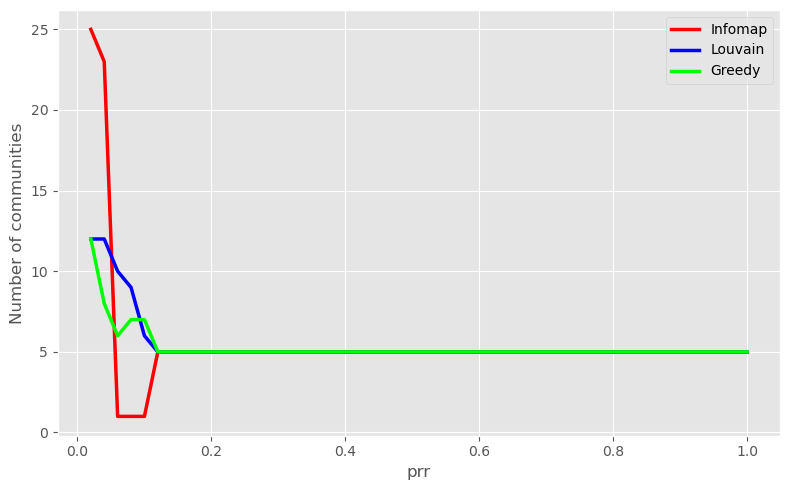

In [40]:
COLOR_PALETTE = {
    'Infomap': '#FF0000',
    'Louvain': '#0000FF',
    'Greedy': '#00FF00'
}

num_communities = []

for prr in networks:
    for algo_name, partitions in zip(
        ["Infomap", "Louvain", "Greedy"],
        [infomap_partitions, louvain_partitions, greedy_partitions]
    ):
        part = partitions[prr]
        num_communities.append({
            "prr": prr,
            "algorithm": algo_name,
            "num_communities": len(part)
        })

num_df = pd.DataFrame(num_communities)
num_df.to_csv(os.path.join(REPORT_FOLDER, "communities_count.csv"), index=False)

plt.figure(figsize=(8, 5))
for algo in num_df['algorithm'].unique():
    subset = num_df[num_df['algorithm'] == algo]
    plt.plot(subset['prr'],
             subset['num_communities'],
             label=algo,
             color=COLOR_PALETTE[algo],
             linewidth=2.5)
plt.xlabel("prr")
plt.ylabel("Number of communities")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "num_communities_vs_prr.png"))
plt.show()


#### 4.2.2 Modularity vs prr
We compute the modularity of each partition for each algorithm and plot its evolution as `prr` increases, to evaluate the strength of the detected community structure.

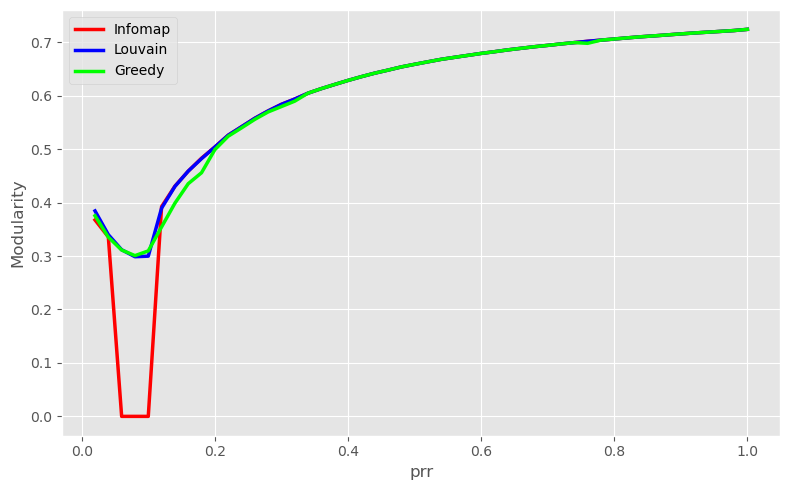

In [41]:

modularity_data = []

for prr, G in networks.items():
    for algo_name, partitions in zip(
        ["Infomap", "Louvain", "Greedy"],
        [infomap_partitions, louvain_partitions, greedy_partitions]
    ):
        part = partitions[prr]
        mod = modularity(G, part)
        modularity_data.append({
            "prr": prr,
            "algorithm": algo_name,
            "modularity": mod
        })

mod_df = pd.DataFrame(modularity_data)
mod_df.to_csv(os.path.join(REPORT_FOLDER, "modularity_scores.csv"), index=False)

plt.figure(figsize=(8, 5))
for algo in mod_df['algorithm'].unique():
    subset = mod_df[mod_df['algorithm'] == algo]
    plt.plot(subset['prr'],
             subset['modularity'],
             label=algo,
             color=COLOR_PALETTE[algo],
             linewidth=2.5)
plt.xlabel("prr")
plt.ylabel("Modularity")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "modularity_vs_prr.png"))
plt.show()



##### 4.2.3 Jaccard Index vs prr
This plot shows how the Jaccard index evolves as `prr` increases. Since `prr` represents the probability of intra-community connections, increasing it should reinforce the community structure. Therefore, we expect the Jaccard index, which measures similarity to the ground truth, to increase as `prr` increases.

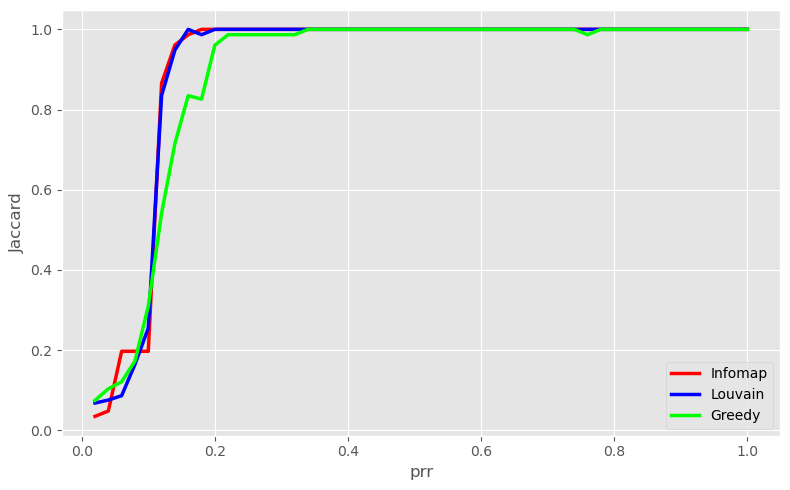

In [42]:
plt.figure(figsize=(8, 5))
for algo in df_scores["algorithm"].unique():
    subset = df_scores[df_scores["algorithm"] == algo]
    plt.plot(subset['prr'],
             subset['Jaccard'],
             label=algo,
             color=COLOR_PALETTE[algo],
             linewidth=2.5)
plt.xlabel("prr")
plt.ylabel("Jaccard")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "jaccard_vs_prr.png"))
plt.show()

#### 4.2.4 Normalized Mutual Information (NMI) vs prr
This plot shows the behavior of NMI, a similarity-based index. Just like Jaccard, we expect NMI to increase with `prr`, as community structure becomes more clearly defined.

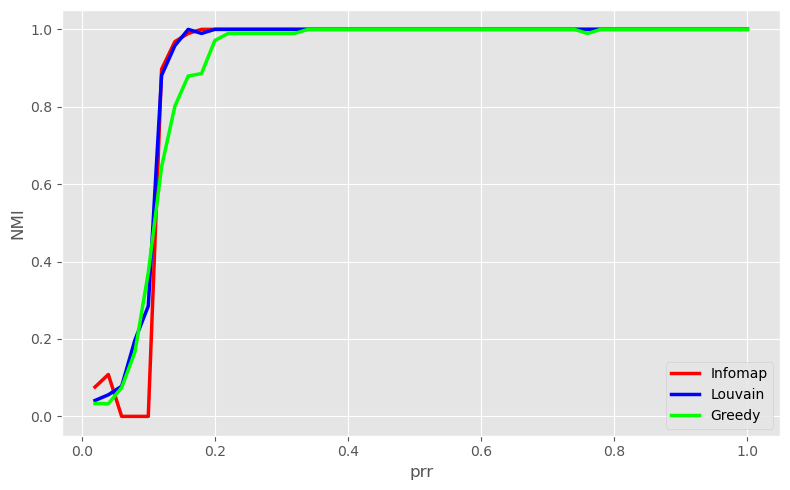

In [43]:
plt.figure(figsize=(8, 5))
for algo in df_scores["algorithm"].unique():
    subset = df_scores[df_scores["algorithm"] == algo]
    plt.plot(subset['prr'],
             subset['NMI'],
             label=algo,
             color=COLOR_PALETTE[algo],
             linewidth=2.5)
plt.xlabel("prr")
plt.ylabel("NMI")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "nmi_vs_prr.png"))
plt.show()

#### 4.2.5 Variation of Information (NVI) vs prr
NVI is a distance metric: the higher it is, the more different the detected partition is from the ground truth. Since increasing `prr` reinforces community structure, the detected partitions should be closer to the ground truth. Thus, we expect NVI to decrease with `prr`.

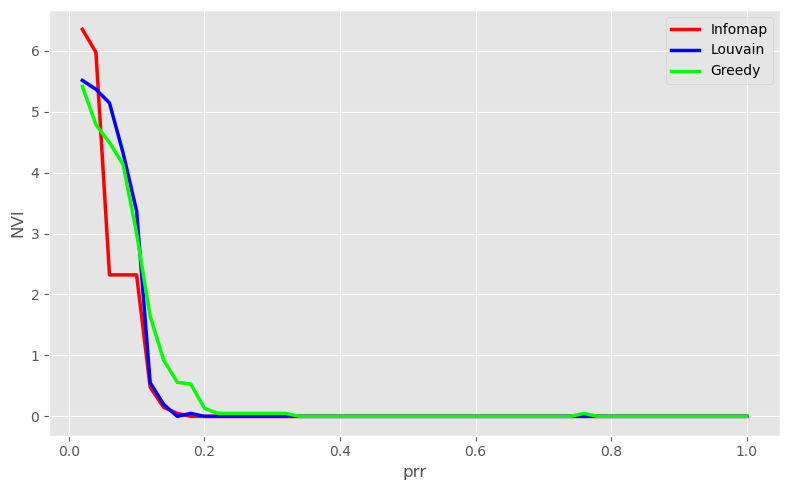

In [44]:
plt.figure(figsize=(8, 5))
for algo in df_scores["algorithm"].unique():
    subset = df_scores[df_scores["algorithm"] == algo]
    plt.plot(subset['prr'],
             subset['NVI'],
             label=algo,
             color=COLOR_PALETTE[algo],
             linewidth=2.5)
plt.xlabel("prr")
plt.ylabel("NVI")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "nvi_vs_prr.png"))
plt.show()

## 5. Network Visualization

### 5.1 Color-coded Community Visualization for prr = 0.02, 0.16, 1.00
We visualize the community structure detected by each algorithm at three different values of `prr`.

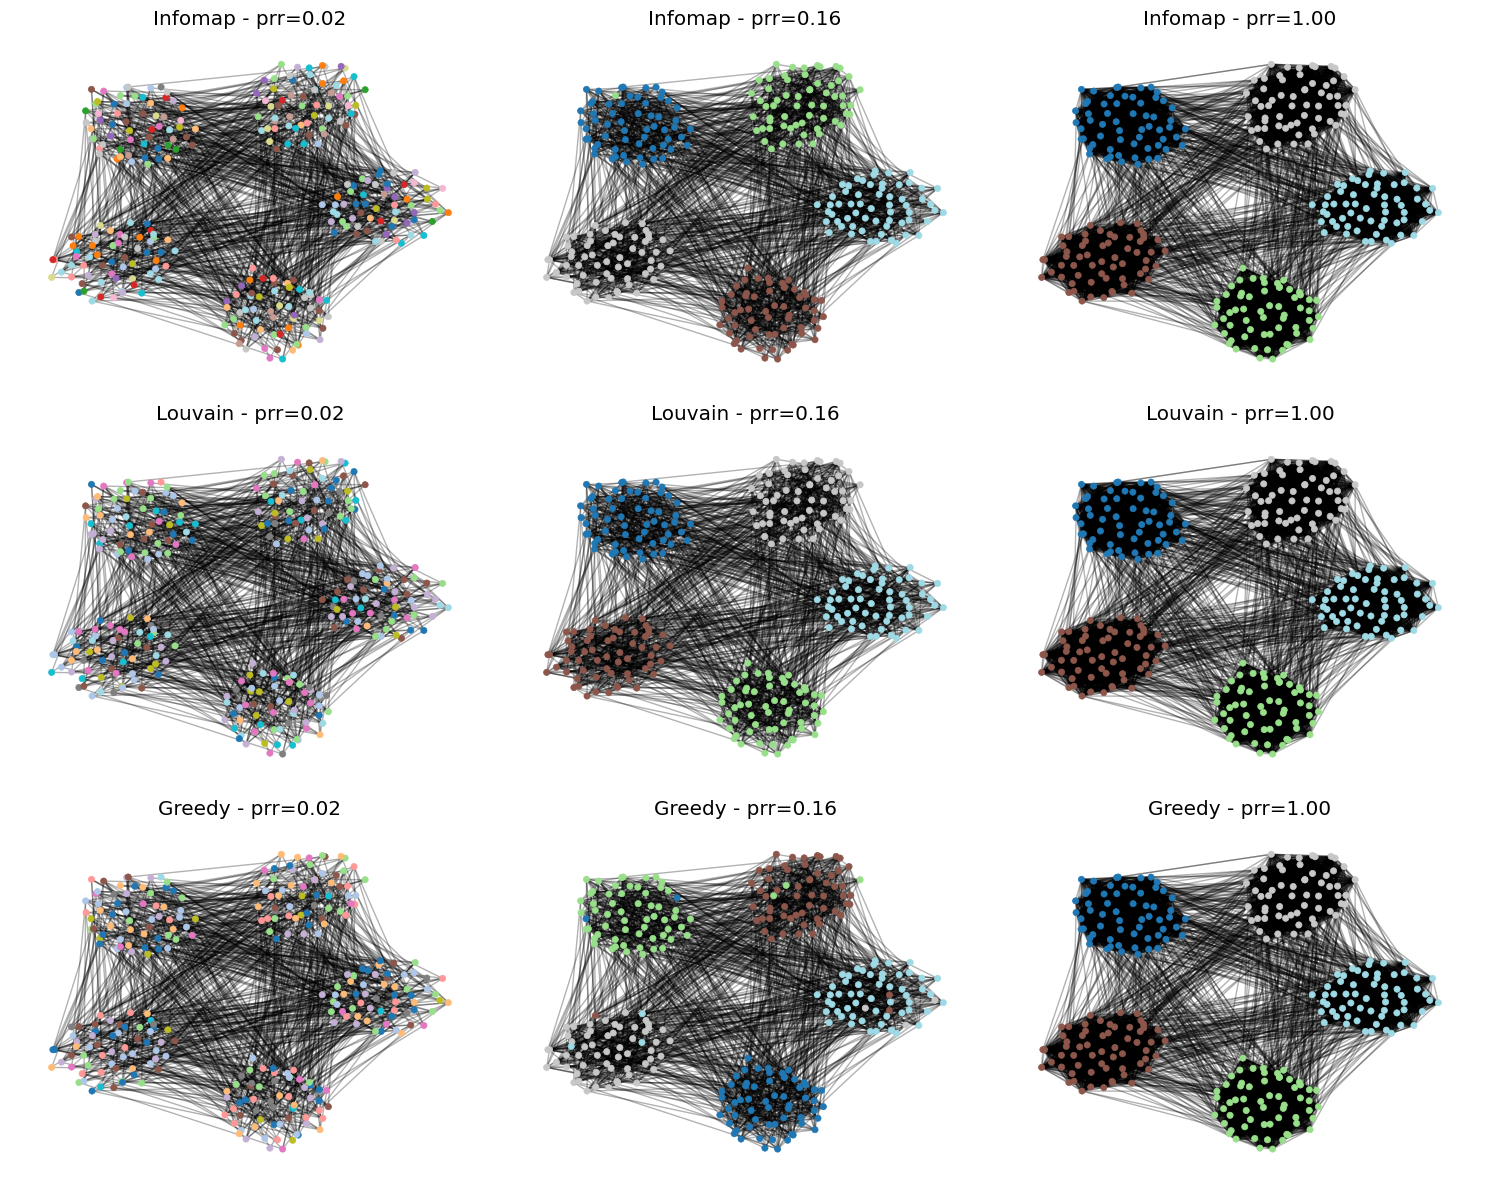

In [45]:

reference_G = networks[1.00]
positions = nx.spring_layout(reference_G, seed=42)

# Function to get color mapping from partition
def community_colors(partition, G):
    color_map = {}
    for i, community in enumerate(partition):
        for node in community:
            color_map[node] = i
    return [color_map[node] for node in G.nodes()]

# Grid Plotting per algorithm
selected_prr = [0.02, 0.16, 1.00]
algorithms = [
    ("Infomap", infomap_partitions),
    ("Louvain", louvain_partitions),
    ("Greedy", greedy_partitions)
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, (algo_name, partition_dict) in enumerate(algorithms):
    for j, prr in enumerate(selected_prr):
        G = networks[prr]
        partition = partition_dict[prr]
        color_list = community_colors(partition, G)

        ax = axes[i, j]
        nx.draw_networkx_nodes(G, pos=positions, node_color=color_list,
                               cmap=plt.cm.tab20, node_size=20, ax=ax)
        nx.draw_networkx_edges(G, pos=positions, alpha=0.3, ax=ax)
        ax.set_title(f"{algo_name} - prr={prr:.2f}")
        ax.set_axis_off()

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_FOLDER, "community_grid_visualization.png"))
plt.show()


## 6. Discussion

### 6.1 Limitations of Modularity
Below we address some conceptual questions to guide the discussion on modularity as an indicator of community structure.

**Q1: What are the limitations of modularity as a metric for evaluating community detection results?**

Modularity-based algorithms (Louvain, Greedy) suffer from the **resolution limit**: in large networks, small but well-formed communities may be merged into larger ones if doing so increases the overall modularity. As a result, meaningful small-scale structures can be missed.

Additionally, modularity may be **misleading in random networks**: even networks generated without any community structure (Erdős-Rényi) can exhibit relatively high modularity values due to random fluctuations. This makes it dangerous to rely solely on Q to infer the presence of meaningful communities.

**Q2: Can we state that a network with Q=0.4 has community structure? Why?**

Based on the observations previously made, although a modularity value of 0.4 might indicate a certain degree of community structure, this alone is not a reliable indicator.



### 6.2 Observations on Differences between Algorithms
This section provides a set of discussion questions aimed at analyzing the behavior of the three algorithms across different levels of noise (`prr`).

**Q1: What is the difference between Louvain, Greedy and Infomap Algorithms?**

MLouvain and Greedy are both modularity-based algorithms, but they differ in their strategy.

**Louvain** is a hierarchical algorithm that works in two main steps. First, it performs local modularity optimization by moving individual nodes into neighboring communities if it increases modularity. Then, it aggregates nodes belonging to the same community into a supernode and repeats the process on this new, compressed graph.

**Greedy**, is an agglomerative approach. It starts with each node in its own community and iteratively merges the pair of communities that leads to the highest increase in modularity. This process continues until all nodes are merged into a single community, and the division with the best modularity score is selected.

**Infomap**, in contrast, is not based on modularity. It takes a dynamic perspective: it simulates a random walker moving across the network and finds the partition that minimizes the expected description length of its trajectory.


**Q2: Are the modularity values obtained equal? Why?**

No, the modularity values obtained by the three algorithms are not always equal, and this is expected due to fundamental differences in how they operate.
  - Louvain and Greedy explicitly optimize modularity, so they generally produce higher modularity values. As prr increases, indicating stronger and more detectable community structure, the modularity increase
  - Infomap, on the other hand, is not based on modularity but on minimizing the description length of a random walk. As a result, the modularity of its partitions is not necessarily high and can even be unstable for low values of prr. This is visible in the plot, where infomap shows low modularity where prr is between 0.0 and 0.2, suggesting that its partitioning at that range doeas not align with what modularity considers optimal.